# Полносвязная нейронная сеть

Fully-connected Neural Network (FCN). В современных статьях чаще используется термин Multi-Layer Perceptron (MLP).

Что нужно сделать, чтобы написать полносвязную сеть для классификации изображений:

1. Превращаем исходные данные в вектор.

>***Примечание***: Для цветного изображения из CIFAR-10 размером $32\times32$ пикселя ($32\times32\times3$) размерность входного вектора будет равна $3072$.

2. Перемножаем матрицу данных с матрицей весов. Размер последней может быть, например, $100\times3072$, где $3072$ — размер входного вектора, а $100$ — количество признаков, которое мы хотим получить. Результат обработки одного входа будет иметь размер $100\times1$.

3. Поэлементно применяем к вектору признаков нелинейную функцию (функцию активации), например, Sigmoid или ReLU. Размерность данных при этом не меняется ($100\times1$). В результате получаем вектор активаций.

4. Используем полученные активации как входные данные для нового слоя. Количество весов слоя будет зависеть от размерности входной матрицы и того, что мы хотим получить на выходе. Если мы делаем классификатор на $10$ классов, то матрица весов должна иметь размерность $10\times100$, и на этом можно остановиться. Но в общем случае количество слоев может быть произвольным.

<img src ="https://ml.gan4x4.ru/msu/dev-2.2/L06/out/modified_model.png" width="600">

$\large h=W_1 \cdot x$
    
$\large S=W_2 \cdot f(h)=W_2 \cdot f(W_1 \cdot x)$

На изображении представлена описанная выше нейронная сеть. Добавление второго слоя позволило модели использовать более одного шаблона на класс. Можно убедиться в этом, обучив модель на датасете CIFAR-10 и визуализировав веса первого слоя модели.

In [ ]:
from torch import nn


class FCNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers_stack = nn.Sequential(
            nn.Linear(3 * 32 * 32, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
        )

    def forward(self, x):
        return self.layers_stack(x)

Скачаем файл с предобученными весами (точность $\approx0.5$)

In [ ]:
!wget -q https://ml.gan4x4.ru/msu/weights/2layer.pt

Загрузим веса в модель:

In [ ]:
import torch

fc_model = FCNet()
weights_in_dict = torch.load("2layer.pt", weights_only=True)
fc_model.load_state_dict(weights_in_dict)

<All keys matched successfully>

**MLP: Набор шаблонов классов, выученных нейросетью.**

Визуализируем веса первого слоя:

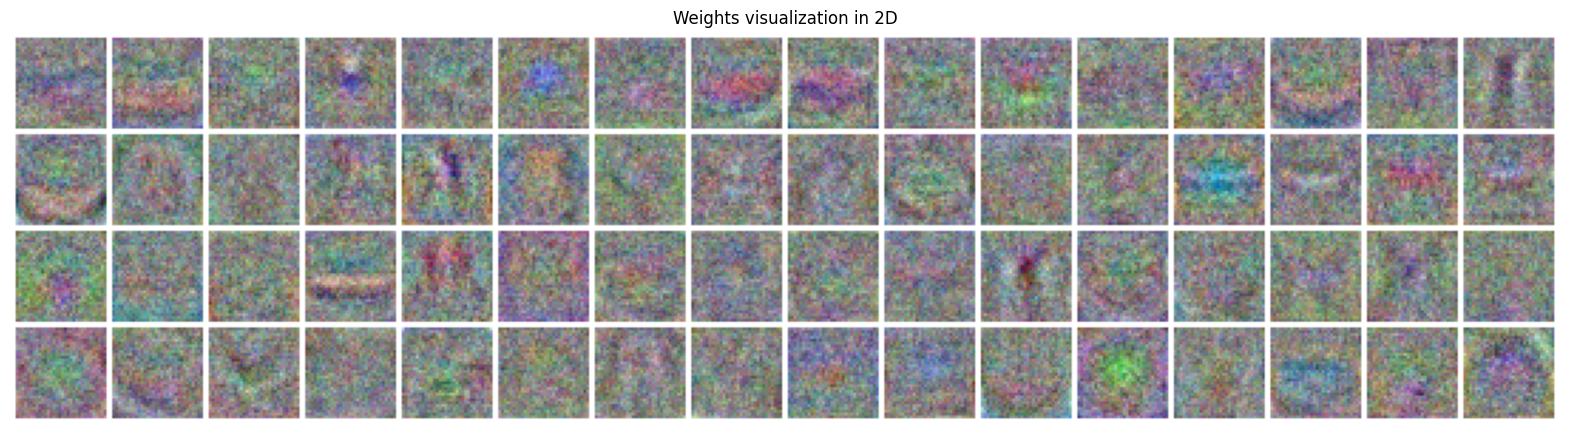

In [ ]:
import matplotlib.pyplot as plt
from torchvision import utils


W1 = fc_model.layers_stack[0].weight.reshape(64, 3, 32, 32)  # layer has 64 neurons
img_grid = utils.make_grid(W1, pad_value=1, normalize=True, nrow=16)

plt.figure(figsize=(20, 12))
plt.title("Weights visualization in 2D")
plt.imshow(img_grid.permute(1, 2, 0).cpu().numpy())  # CHW -> HWC
plt.axis("off")
plt.show()

За счёт создания нескольких шаблонов для каждого из классов многослойные архитектуры в общем случае показывают более высокую эффективность в задачах классификации изображений. Однако и здесь есть что улучшить.

## Нарушение связей между соседними пикселями

При вытягивании изображения в вектор мы теряем информацию о взаимном расположении пикселей на исходной картинке.





 <img src ="https://ml.gan4x4.ru/msu/dev-2.2/L06/out/img_to_vector_problem.png" width="900">

In [ ]:
!wget -q https://ml.gan4x4.ru/msu/dev-2.1/L06/digit.png

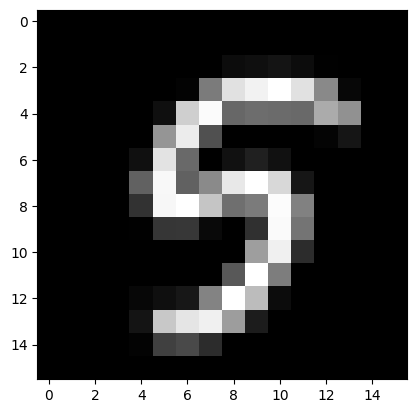

In [ ]:
import numpy as np
from PIL import Image


image = Image.open("digit.png")
img_np = np.array(image)
plt.imshow(img_np, cmap="gray")
plt.show()

In [ ]:
print(img_np)

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0  12  15  20  12   1   0   0   0]
 [  0   0   0   0   0   0   3 123 225 242 255 225 137   7   0   0]
 [  0   0   0   0   0  15 207 251 103 109 107 105 171 145   0   0]
 [  0   0   0   0   0 149 236  80   0   0   0   0   4  21   0   0]
 [  0   0   0   0  16 228 106   0  17  33  17   0   0   0   0   0]
 [  0   0   0   0  97 248  98 138 232 255 216  22   0   0   0   0]
 [  0   0   0   0  50 247 255 197 111 123 252 129   0   0   0   0]
 [  0   0   0   0   1  54  55   9   0  49 250 116   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0 158 240  44   0   0   0   0]
 [  0   0   0   0   0   0   0   0  88 255 125   0   0   0   0   0]
 [  0   0   0   0   7  15  23 132 255 188  12   0   0   0   0   0]
 [  0   0   0   0  20 200 229 240 157  28   0   0   0   0   0   0]
 [  0   0   0   0   3  64  73  45   0   0   0   0   0   0   0 

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12, 15, 20, 12, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 123, 225, 242, 255, 225, 137, 7, 0, 0, 0, 0, 0, 0, 0, 15, 207, 251, 103, 109, 107, 105, 171, 145, 0, 0, 0, 0, 0, 0, 0, 149, 236, 80, 0, 0, 0, 0, 4, 21, 0, 0, 0, 0, 0, 0, 16, 228, 106, 0, 17, 33, 17, 0, 0, 0, 0, 0, 0, 0, 0, 0, 97, 248, 98, 138, 232, 255, 216, 22, 0, 0, 0, 0, 0, 0, 0, 0, 50, 247, 255, 197, 111, 123, 252, 129, 0, 0, 0, 0, 0, 0, 0, 0, 1, 54, 55, 9, 0, 49, 250, 116, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 158, 240, 44, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 88, 255, 125, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 15, 23, 132, 255, 188, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 20, 200, 229, 240, 157, 28, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 64, 73, 45, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


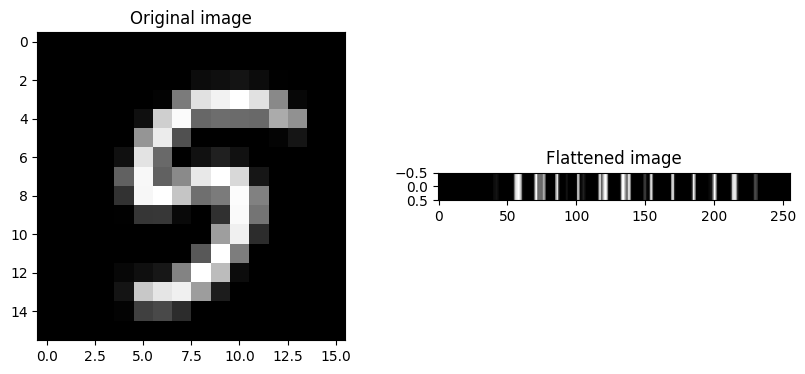

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
ax[0].imshow(img_np, cmap="gray")
ax[1].imshow(img_np.reshape(1, -1), aspect=20, cmap="gray")
ax[0].set_title("Original image")
ax[1].set_title("Flattened image")

vector = np.array(image).flatten()
print(list(vector))

Пиксели, которые были соседними и составляли цельный объект, могут оказаться на большом расстоянии внутри результирующего вектора. Получается, что мы просто удалили информацию об их близости, важность которой нам как людям очевидна.

Идея полносвязной нейронной сети пришла к нам из математической модели восприятия информации мозгом ([перцептрон Розенблатта ✏️[blog]](https://habr.com/ru/companies/sberdevices/articles/529932/)). Возможно, чтобы получить хорошие результаты при обработке изображений, нужно посмотреть, как работает человеческий глаз?


### Рецептивное поле

В полносвязной сети каждый нейрон "видит" сразу все изображение (все данные). Наша зрительная система работает иначе.

*  Каждый фоторецептор на сетчатке нашего глаза (палочка или колбочка) реагирует только на свет, попавший на него.

* Сигнал от фоторецептора попадает на нейрон следующего уровня ([биполярная клетка 📚[wiki]](https://ru.wikipedia.org/wiki/%D0%91%D0%B8%D0%BF%D0%BE%D0%BB%D1%8F%D1%80%D0%BD%D1%8B%D0%B5_%D0%BA%D0%BB%D0%B5%D1%82%D0%BA%D0%B8_%D1%81%D0%B5%D1%82%D1%87%D0%B0%D1%82%D0%BA%D0%B8)). Этот нейрон уже соединен с несколькими фоторецепторами. Область, в которой они локализованы, называется **рецептивным полем**.
Нейрон возбуждается при определенной комбинации сигналов от связанных с ним рецепторных клеток. По сути, он реагирует на простой, локально расположенный паттерн.

* Клетки уровнем выше (ганглиозные) собирают информацию с нескольких близко расположенных биполярных клеток и активируются при уникальной комбинации сигналов с них. Их рецептивное поле больше, и паттерны, на которые они реагируют, сложнее.


**Рецептивное поле** нейрона — это участок с рецепторами, с которых он прямо или опосредованно, через другие нейроны, получает информацию.



<img src ="https://ml.gan4x4.ru/msu/dev-2.2/L06/out/brain.png" width="1000">

* Далее сигнал передается в мозг, но там связи между нейронами продолжают оставаться иерархическими. Рецептивное поле нейронов растет, и паттерны, на которые они активируются, становятся все более и более сложными.